In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd

In [62]:
### Data params
log_ens = np.linspace(1,6,51) # log (base 10) of the energy values used for fitting

### Fit Parameters
dif_orders = [3, 3, 3] # order of difference to penalize for smoothing [a,b,E]
smoothness = [5,5,2] # degree of smoothing along each dimension [a,b,E]
c_a = 12 # Number of basis splines along a-dimension
c_b = 12 # Number of basis splines along b-dimension
c_E = 6 # Number of basis splines along E-dimension
n_a = 300 # Number of histogram bins along a-dimension
n_b = 301 # Number of histogram bins along b-dimension
n_E = len(log_ens) # Number of energy levels used for fitting

ga = np.vectorize(lambda a : a**(-1/2)) # Function to transform a values into range (0,1)
gb = np.vectorize(lambda b : 1/(1+b**2)) # Function to transform a values into range (0,1)

### Fitting process parameters
num_iters = 100 # Number of iterations of least square regression for fitting, can be quit early
perform_likelihood_test = True # Perform likelihood test on test sample for monitoring progress
test_sample_size = 4301 # Number of elements in the testing data set
theta_0 = np.random.default_rng().random(c_a*c_b*c_E) # Initial guess for spline parameters

output_file = "../FittedCoefs.npy"

In [63]:
### Reading into Dictionary of pandas dataframes --> we can change the reading format
def format_energy(num):
    num_str = "{:.5e}".format(num)
    coefficient, exponent = num_str.split('e')
    exponent2 = exponent.replace('+0', '')
    if exponent2==exponent:
        raise Exception("Invalid energy for this formating. Energy must be within the interval [1,1e10)")
    coefficient = coefficient.ljust(7, '0')
    return f"{coefficient}E{exponent2}"
energy_strs = [format_energy(num) for num in np.logspace(1,6,51)]
Dat = {}
header = [str(i) for i in np.linspace(0,4990,500)] + \
    ['Energy','ltot','gammaA','gammaB','covAA','covAB','covBB','NumPeaks','Peak1','Peak2','Peak3','Peak4','Peak5']
for energy_str in energy_strs:
    Dat[energy_str] = pd.read_csv('../EnSplit/PION_' + energy_str + '.csv',names = header).dropna(subset = 'gammaA')

In [64]:
## Define the knots
a_k = np.linspace(0,1,c_a - 3 + 1)
b_k = np.linspace(0,1,c_b - 3 + 1)
E_k = np.linspace(1,6,c_E - 3 + 1)
## add knot values on above and below the range of interest
a_k = sc.interpolate.interp1d(np.arange(c_a - 3 + 1),a_k,bounds_error=False,fill_value='extrapolate')(np.arange(-3,c_a + 1))
b_k = sc.interpolate.interp1d(np.arange(c_b - 3 + 1),b_k,bounds_error=False,fill_value='extrapolate')(np.arange(-3,c_b + 1))
E_k = sc.interpolate.interp1d(np.arange(c_E - 3 + 1),E_k,bounds_error=False,fill_value='extrapolate')(np.arange(-3,c_E + 1))
knots = (a_k,b_k,E_k)
'''
Makes the knots for the given Coefficients
Provided a range of valid values for each of the three parameters
Params:
    a_reg - number of valid regions in the a dimension
    b_reg - number of valid regions in the b dimension
    E_reg - number of valid regions in the E dimension
    a_min - minumum value in the a dimension, [Default = 0]
    a_max - maximum value in the a dimension, [Default = 1]
    b_min - minumum value in the b dimension, [Default = 0]
    b_max - maximum value in the b dimension, [Default = 1]
    E_min - minumum value in the E dimension, [Default = 1]
    E_max - maximum value in the E dimension, [Default = 6]
            Note that returned knot values will extend past these values for b-spline fitting purposes
Return:
    a_k - 1d array of knots for the a dimension
    b_k - 1d array of knots for the b dimension
    E_k - 1d array of knots for the E dimension
'''
def make_knots(a_reg,b_reg,E_reg,a_min=0,a_max=1,b_min=0,b_max=1,E_min=1,E_max=6):
    c_a = a_reg + 3
    c_b = b_reg + 3
    c_E = E_reg + 3
    ## Define the knots
    a_k = np.linspace(a_min,a_max,c_a - 3 + 1)
    b_k = np.linspace(b_min,b_max,c_b - 3 + 1)
    E_k = np.linspace(E_min,E_max,c_E - 3 + 1)
    ## add knot values on above and below the range of interest
    a_k = sc.interpolate.interp1d(np.arange(c_a - 3 + 1),a_k,bounds_error=False,fill_value='extrapolate')(np.arange(-3,c_a + 1))
    b_k = sc.interpolate.interp1d(np.arange(c_b - 3 + 1),b_k,bounds_error=False,fill_value='extrapolate')(np.arange(-3,c_b + 1))
    E_k = sc.interpolate.interp1d(np.arange(c_E - 3 + 1),E_k,bounds_error=False,fill_value='extrapolate')(np.arange(-3,c_E + 1))
    return a_k,b_k,E_k

'''
Converts basis spline coefficients into coefficients in the polynomial basis
Params
    Theta - Array with shape (c_a,c_b,c_E) of coefficients for a basis spline
    knots: tuple (a_k,b_k,E_k) where each element is the 1d array of the knots defining the spline regions along each dimension
           if not supplied, make_knots is called with the default values.
Returns
    Coefs - Array with shape (c_a-3, c_b-3, c_E-3, 4, 4, 4) . 
           Coefs[i,j,k,q,r,s] is the coeficient on the a**q b**r E**s term in the space right after knot a_k[i+3], b_k[j+3], and E_k[k+3]
'''
def BSpline2Poly(Theta,knots=None):
    if knots == None:
        knots = make_knots(Theta.shape[0]-3,Theta.shape[1]-3,Theta.shape[2]-3)
    a_k = knots[0]
    b_k = knots[1]
    E_k = knots[2]
    
    D_a = a_k[1] - a_k[0]
    D_b = b_k[1] - b_k[0]
    D_E = E_k[1] - E_k[0]
    Coefs = np.zeros((Theta.shape[0] - 3,Theta.shape[1] - 3,Theta.shape[2] - 3,4,4,4))
    BSplinePieces_a = np.zeros((Theta.shape[0],4,4))
    BSplinePieces_b = np.zeros((Theta.shape[1],4,4))
    BSplinePieces_E = np.zeros((Theta.shape[2],4,4))
    '''
    BSplinePieces_?[i,j,k] holds the coefficient on the x**k term of the j-th piece of the i-th basis spline
    '''
    for i in range(Theta.shape[0]):
        for j in range(4):
            BSplinePieces_a[i,j,:] = BSplinePiece(j,a_k[0],D_a,i)
    for i in range(Theta.shape[1]):
        for j in range(4):
            BSplinePieces_b[i,j,:] = BSplinePiece(j,b_k[0],D_b,i)
    for i in range(Theta.shape[2]):
        for j in range(4):
            BSplinePieces_E[i,j,:] = BSplinePiece(j,E_k[0],D_E,i)
    for q in range(4):
        for r in range(4):
            for s in range(4):
                for l in range(4):
                    for m in range(4):
                        for n in range(4):
                            Coefs[:,:,:,q,r,s] += Theta[l:Coefs.shape[0]+l,m:Coefs.shape[1]+m,n:Coefs.shape[2]+n] \
                                * np.tile(BSplinePieces_a[l:Coefs.shape[0]+l,3-l,q].reshape((Coefs.shape[0],1,1)),(1,Coefs.shape[1],Coefs.shape[2])) \
                                * np.tile(BSplinePieces_b[m:Coefs.shape[1]+m,3-m,r].reshape((1,Coefs.shape[1],1)),(Coefs.shape[0],1,Coefs.shape[2])) \
                                * np.tile(BSplinePieces_E[n:Coefs.shape[2]+n,3-n,s].reshape((1,1,Coefs.shape[2])),(Coefs.shape[0],Coefs.shape[1],1))

    return Coefs
    
'''
constructs the coefficients for a 3rd order BSpline with evenly space knots in the polynomial basis
Params:
    piece_num - which of the four sections of the BSpline basis element (integer 0 (leftmost) to 3 (rightmost))
    x_0 - leftmost knot position
    D - distance between knots
    n - index of basis spline (0 corresponds to basis element originating from x_0)
Returns:
    coefs: coefs[i] is the coefficient on the x**i term in the specified section of the basis element
'''
def BSplinePiece(piece_num,x_0,D,n):
    match piece_num:
        case 0:
            return np.array([-D**3*n**3 - 3*D**2*n**2*x_0 - 3*D*n*x_0**2 - x_0**3,3*D**2*n**2 + 6*D*n*x_0 + 3*x_0**2,-3*D*n - 3*x_0,1])/(6*D**3)
        case 1:
            return np.array([3*D**3*n**3 + 12*D**3*n**2 + 12*D**3*n + 4*D**3 + 9*D**2*n**2*x_0 + 24*D**2*n*x_0 + 12*D**2*x_0 + 9*D*n*x_0**2 + 12*D*x_0**2 + 3*x_0**3,
                            -9*D**2*n**2 - 24*D**2*n - 12*D**2 - 18*D*n*x_0 - 24*D*x_0 - 9*x_0**2,
                            9*D*n + 12*D + 9*x_0,-3])/(6*D**3)
        case 2:
            return np.array([-3*D**3*n**3 - 24*D**3*n**2 - 60*D**3*n - 44*D**3 - 9*D**2*n**2*x_0 - 48*D**2*n*x_0 - 60*D**2*x_0 - 9*D*n*x_0**2 - 24*D*x_0**2 - 3*x_0**3,
                             9*D**2*n**2 + 48*D**2*n + 60*D**2 + 18*D*n*x_0 + 48*D*x_0 + 9*x_0**2,
                             -9*D*n - 24*D - 9*x_0,3])/(6*D**3)
        case 3:
            return np.array([D**3*n**3 + 12*D**3*n**2 + 48*D**3*n + 64*D**3 + 3*D**2*n**2*x_0 + 24*D**2*n*x_0 + 48*D**2*x_0 + 3*D*n*x_0**2 + 12*D*x_0**2 + x_0**3,
                            -3*D**2*n**2 - 24*D**2*n - 48*D**2 - 6*D*n*x_0 - 24*D*x_0 - 3*x_0**2,
                            3*D*n + 12*D + 3*x_0,-1])/(6*D**3)
    
'''
Given a 6d array of coefficients, evaluate the spline at the given array of points
Params:
    a,b,E - input parameter values
    Coefs - Coefs[i,j,k,q,r,s] is the coefficient on the a**q b**r E**s term in the i-th a region, j-th b region, and k-th E region
    knots: tuple (a_k,b_k,E_k) where each element is the 1d array of the knots defining the spline regions along each dimension
           if not supplied, make_knots is called with the default values.
Returns:
    Result of evaluating BSpline at the provided a,b,E values
'''
def Eval_from_Coefs(a,b,E,Coefs,knots=None):
    ## if knots aren't specified generate them from default values
    if knots == None:
        knots = make_knots(Coefs.shape[0],Coefs.shape[1],Coefs.shape[2])
    a_k = knots[0]
    b_k = knots[1]
    E_k = knots[2]
    a_i = np.searchsorted(a_k[3:-3], a, side='right')
    b_i = np.searchsorted(b_k[3:-3], b, side='right')
    E_i = np.searchsorted(E_k[3:-3], E, side='right')

    a_i -= (a_i > Coefs.shape[0]) # so that things don't break at the upper boundaries
    b_i -= (b_i > Coefs.shape[1])
    E_i -= (E_i > Coefs.shape[2])
    
    Z = 0
    for l in range(4):
        for m in range(4):
            for n in range(4):
                Z += Coefs[a_i-1,b_i-1,E_i-1,l,m,n] * a**l * b**m * E**n
    return np.exp(Z)

'''
Integrate each region of the spline at a specified energy and return a grid of the integral in each region
Params:
    Coefs: Coefs[i,j,k,q,r,s] is the coefficient on the a**q b**r E**s term in the intersection of the 
           i-th a region, j-th b region, and k-th E region
    knots: tuple (a_k,b_k,E_k) where each element is the 1d array of the knots defining the spline regions along each dimension
           if not supplied, make_knots is called with the default values.
    num_quad_nodes: number of nodes used for guassian quadrature, [Default = 7]
Returns:
    result[i,j,k] is the integral over the intersection of the i-th a region, j-th b region, and k-th E region
'''
def integrate_grid(Coefs,E,knots=None,num_quad_nodes=7):
    ## if knots aren't specified generate them from default values
    if knots == None:
        knots = make_knots(Coefs.shape[0],Coefs.shape[1],Coefs.shape[2])
    a_k = knots[0]
    b_k = knots[1]
    E_k = knots[2]
    
    ## create nodes for gaussian quadrature
    nodes_1d, weights_1d = np.polynomial.legendre.leggauss(num_quad_nodes)
    weights = np.tile(weights_1d,(num_quad_nodes,1)) * np.tile(weights_1d,(num_quad_nodes,1)).T
    nodes = np.tile(nodes_1d,(num_quad_nodes,1))
    nodes_array = np.tile(nodes.reshape(1,1,num_quad_nodes,num_quad_nodes),(Coefs.shape[0],Coefs.shape[1],1,1))
    nodesT_array = np.tile(nodes.T.reshape(1,1,num_quad_nodes,num_quad_nodes),(Coefs.shape[0],Coefs.shape[1],1,1))
    weights_array = np.tile(weights.reshape(1,1,num_quad_nodes,num_quad_nodes),(Coefs.shape[0],Coefs.shape[1],1,1))
    E_i = np.searchsorted(E_k[3:-3],E,side='right')
    E_i -= (E_i > Coefs.shape[2])

    Z = np.zeros((*Coefs.shape[:2],num_quad_nodes,num_quad_nodes))
    ## Z[grid of regions a][grid of regions b][grid of nodes a][grid of nodes b]

    l_a = np.tile(a_k[3:-4].reshape(-1,1,1,1),(1,Coefs.shape[1],num_quad_nodes,num_quad_nodes))
    h_a = np.tile(a_k[4:-3].reshape(-1,1,1,1),(1,Coefs.shape[1],num_quad_nodes,num_quad_nodes))
    l_b = np.tile(b_k[3:-4].reshape(1,-1,1,1),(Coefs.shape[0],1,num_quad_nodes,num_quad_nodes))
    h_b = np.tile(b_k[4:-3].reshape(1,-1,1,1),(Coefs.shape[0],1,num_quad_nodes,num_quad_nodes))
    
    for l in range(4):
        for m in range(4):
            for n in range(4):
                Z += np.tile(Coefs[:,:,E_i-1,l,m,n].reshape((Coefs.shape[0],Coefs.shape[1],1,1)),(1,1,num_quad_nodes,num_quad_nodes)) \
                        * (nodes_array*(h_a-l_a)/2 + (l_a+h_a)/2)**l * (nodesT_array*(h_b-l_b)/2 + (l_b+h_b)/2)**m * E**n
    return np.sum(np.exp(Z) * weights * (a_k[1]-a_k[0])*(b_k[1]-b_k[0])/4,axis=(2,3))

'''
perform a likelihood_test on the provided sample using the given Coefs
Params:
    a_sample: array of a values in the test sample
    b_sample: array of b values in the test sample
    E: log energy value at which we are testing
    Coefs: coefficients defining the model we are testing
           Coefs[i,j,k,q,r,s] is the coefficient on the (a**q b**r E**s) term in the intersection of the 
           i-th a region, j-th b region, and k-th E region
    knots: tuple (a_k,b_k,E_k) where each element is a 1d array of the knots defining the spline regions along each dimension
           if not supplied, make_knots is called with the default values.
Returns:
    log-likelihood of the given sample
'''
def likelihood_test(a_sample,b_sample,E,Coefs,knots=None):
    ## If knots aren't specified, generate them from default values
    if knots == None:
        knots = make_knots(Coefs.shape[0],Coefs.shape[1],Coefs.shape[2])
    norm_factor = integrate_grid(Coefs,E,knots).sum()
    return np.log(Eval_from_Coefs(a_sample,b_sample,E,Coefs,knots)).sum() - (np.size(a_sample) * np.log(norm_factor))

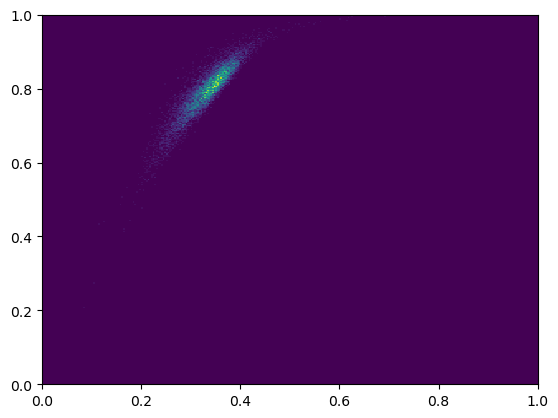

In [65]:
## Make Y matrix of histogram values to fit 
Y = np.zeros((n_a,n_b,n_E))
bins_a = np.linspace(0,1,n_a + 1)
bins_b = np.linspace(0,1,n_b + 1)
for i in range(n_E):
    df = Dat[energy_strs[i]]
    avals = ga(df.gammaA)
    bvals = gb(df.gammaB)
    Y[:,:,i],_,_,_ = plt.hist2d(avals,bvals,bins=(bins_a,bins_b),density=True)

In [66]:
'''
Constructs difference matrix of specified size and order, used for penalizing differences
'''
def dif_mat(size,order):
    D1 = np.identity(size) - np.vstack((np.zeros((1,size)),np.identity(size)[:-1,:]))
    D = np.identity(size)
    k = order
    while k > 0:
        D = D @ D1
        k -= 1
    return D[order:,:]

# Make B_i and G(B_i)
x_a,x_b,x_E = (bins_a[1:] + bins_a[:-1])/2, (bins_b[1:] + bins_b[:-1])/2, log_ens
B_a = np.zeros((n_a,c_a))
B_b = np.zeros((n_b,c_b))
B_E = np.zeros((n_E,c_E))
for i in range(n_a):
    for j in range(c_a):
        B_a[i,j] = sc.interpolate.BSpline.basis_element(a_k[j:j + 3 + 2],extrapolate = False)(x_a[i])
        if np.isnan(B_a[i,j]) : B_a[i,j] = 0
for i in range(n_b):
    for j in range(c_b):
        B_b[i,j] = sc.interpolate.BSpline.basis_element(b_k[j:j + 3 + 2],extrapolate = False)(x_b[i])
        if np.isnan(B_b[i,j]) : B_b[i,j] = 0
for i in range(n_E):
    for j in range(c_E):
        B_E[i,j] = sc.interpolate.BSpline.basis_element(E_k[j:j + 3 + 2],extrapolate = False)(x_E[i])
        if np.isnan(B_E[i,j]) : B_E[i,j] = 0
GB_a = np.kron(B_a,np.ones(c_a))*np.kron(np.ones(c_a),B_a)
GB_b = np.kron(B_b,np.ones(c_b))*np.kron(np.ones(c_b),B_b)
GB_E = np.kron(B_E,np.ones(c_E))*np.kron(np.ones(c_E),B_E)

GB_a_sT = sc.sparse.csr_array(GB_a.T)
GB_b_sT = sc.sparse.csr_array(GB_b.T)
GB_E_sT = sc.sparse.csr_array(GB_E.T)

# Make difference matrix, P
P_a = sc.sparse.csr_array(dif_mat(c_a,dif_orders[0]).T @ dif_mat(c_a,dif_orders[0]))
P_b = sc.sparse.csr_array(dif_mat(c_b,dif_orders[1]).T @ dif_mat(c_b,dif_orders[1]))
P_E = sc.sparse.csr_array(dif_mat(c_E,dif_orders[2]).T @ dif_mat(c_E,dif_orders[2]))

P_s = smoothness[0] * sc.sparse.kron(P_a,np.identity(c_b * c_E)) \
  + smoothness[1] * sc.sparse.kron(sc.sparse.kron(np.identity(c_a),P_b),np.identity(c_E)) \
  + smoothness[2] * sc.sparse.kron(np.identity(c_a * c_b),P_E)

del P_a,P_b,P_E,GB_a,GB_b,GB_E

In [67]:
'''
This block performs the fitting.
It will stop after "num_iters" iterations, but can be interupted at any point.
The value of the coefficients in the spline basis will be saved to "theta"
'''
if perform_likelihood_test:
    test_sample = np.zeros([test_sample_size,2,51])
    for index, energy_str in enumerate(energy_strs):
        samp = Dat[energy_str].sample(n = test_sample_size)
        test_sample[:,0,index] = ga(samp.gammaA)
        test_sample[:,1,index] = gb(samp.gammaB)
theta = theta_0
for i in range(num_iters):
    print(f'Running iteration {i}...')
    # thetas[:,i] = theta
    _ = np.moveaxis((B_a @ theta.reshape(c_a,c_b*c_E)).reshape(n_a,c_b,c_E),0,-1)
    _ = np.moveaxis((B_b @ _.reshape(c_b,c_E*n_a)).reshape(n_b,c_E,n_a),0,-1)
    Eta = np.moveaxis((B_E @ _.reshape(c_E,n_a*n_b)).reshape(n_E,n_a,n_b),0,-1)
    
    W = np.exp(Eta)
    Z = Eta + np.exp(-Eta)*(Y - np.exp(Eta))
    
    ## Make the updated (B.T * W_delta * z)
    WZ = Eta*W + Y - np.exp(Eta)
    _ = np.moveaxis((B_a.T @ WZ.reshape(n_a,n_b*n_E)).reshape(c_a,n_b,n_E),0,-1)
    _ = np.moveaxis((B_b.T @ _.reshape(n_b,n_E*c_a)).reshape(c_b,n_E,c_a),0,-1)
    BWz = np.moveaxis((B_E.T @ _.reshape(n_E,c_a*c_b)).reshape(c_E,c_a,c_b),0,-1).reshape(-1)
    W_s = sc.sparse.csc_array(W.reshape((n_a,n_b*n_E)))
    
    GW  = (GB_a_sT @ W_s).tocoo()
    H1_s = sc.sparse.csc_array((GW.data,(GW.coords[1]//n_E, c_a**2 * (GW.coords[1] % n_E) + GW.coords[0])), shape=(n_b,n_E*c_a**2))
    
    GH1 = (GB_b_sT @ H1_s).tocoo()
    H2_s = sc.sparse.csc_array((GH1.data,(GH1.coords[1]//c_a**2, c_b**2 * (GH1.coords[1] % c_a**2) + GH1.coords[0])), shape=(n_E,c_a**2 * c_b**2))
    
    GH2 = (GB_E_sT @ H2_s).tocoo()
    H3_s = sc.sparse.coo_array((GH2.data,(GH2.coords[1]//c_b**2, c_E**2 * (GH2.coords[1] % c_b**2) + GH2.coords[0])), shape=(c_a**2,c_b**2 * c_E**2))
    
    # Reshape into (B.T * W * B) matrix form
    l,m = H3_s.coords
    p = (l//c_a) % c_a
    pp = l % c_a
    q = (m//(c_b*c_E**2)) % c_b
    qp = (m//c_E**2) % c_b
    r = (m//c_E) % c_E
    rp = m % c_E
    BWB_s = sc.sparse.csr_array((H3_s.data,(p*c_b*c_E + q*c_E + r,pp*c_b*c_E + qp*c_E + rp)),shape=(c_a*c_b*c_E,c_a*c_b*c_E))
    print('    Running least squares...')
    res = sc.sparse.linalg.lsqr(BWB_s+P_s,BWz)
    theta = res[0]
    print(f'        Least squares R^2: {res[3]:5.3e}')
    print(f'        Least squares loops run: {res[2]:}')
    if perform_likelihood_test:
        print('    Performing likelihood test...')
        Coefs_sofar = BSpline2Poly(theta.reshape((c_a,c_b,c_E)))
        lls = [likelihood_test(test_sample[:,0,i],test_sample[:,1,i],log_ens[i],Coefs_sofar,knots) for i in range(n_E)]
        print(f'        Log-likelihood: {np.sum(lls):5.3e}')

Running iteration 0...
    Running least squares...
        Least squares R^2: 1.112e+02
        Least squares loops run: 1728
    Performing likelihood test...
        Log-likelihood: 1.605e+05
Running iteration 1...
    Running least squares...
        Least squares R^2: 1.854e+08
        Least squares loops run: 31
    Performing likelihood test...
        Log-likelihood: 9.745e+04
Running iteration 2...
    Running least squares...
        Least squares R^2: 6.574e+07
        Least squares loops run: 23
    Performing likelihood test...
        Log-likelihood: 1.236e+05
Running iteration 3...
    Running least squares...
        Least squares R^2: 2.441e+07
        Least squares loops run: 22
    Performing likelihood test...
        Log-likelihood: 1.474e+05
Running iteration 4...
    Running least squares...
        Least squares R^2: 8.782e+06
        Least squares loops run: 22
    Performing likelihood test...
        Log-likelihood: 1.630e+05
Running iteration 5...
    Runnin

KeyboardInterrupt: 

In [68]:
## Convert the coefficients to the polynomial basis (1,x,x**2,x**3,...)
## Then save to "output_file"
np.save(output_file,BSpline2Poly(theta.reshape((c_a,c_b,c_E))))